## Пункт 3: учёт ограничения на угловую скорость

В этом ноутбуке решается задача оптимизации для определения ориентации, подходящей под органичение на угловую скорость. Исходя из результатов можно утверждать, что такие ограничения срабатывают для орбит с околонулевой долготой восходящего узла (отсчитывается относительно оси Х инерциальной системы)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from orientation_handler import SpacecraftOrientationHandler
from orbital_handler import OrbitalFrameOrientationHandler
from optimizer import OptimizeSpacecraftOrientation


Задаем параметры плоскости орбиты КА и большую полуось (остальное определяется из того, что орбита круговая)

In [3]:
def calc_inclunation(theta, raan):
    """
    Расчет наклонения полярной орбиты в инерциальной системе XYZ
    theta: угол между проекцией Земной оси на плоскость XY и направлением на Солнце (осью Х)
    raan: ДВУ орбиты в инерциальной системе
    """
    alpha = (90 - 23.44) / 180 * np.pi
    return np.pi / 2 - np.abs(np.arctan(np.sin(theta - raan) / np.tan(alpha)))

In [4]:
# Гравитационный параметер Земли 
mu = 398600.4415  # км^3 / c^2
# Радиус орбиты (большая полуось)
a = 6371 + 800    # км
# Долгта восходящего узла в инерциальной системе
Omega = np.pi / 400
# Наклонение полярной орбиты в инерциальной системе (нужно задать параметр theta, см. функцию выше)
i = calc_inclunation(theta=np.pi/4 , raan=Omega)

print("Наклонение орбиты: ", np.round(i * 180 / np.pi, 2), "градусов")
print("Долгота восходящего узла: ", np.round(Omega * 180 / np.pi, 2), "градусов")

Наклонение орбиты:  73.08 градусов
Долгота восходящего узла:  0.45 градусов


In [5]:
spacefraft_orientation = SpacecraftOrientationHandler(a, i, Omega, mu)
orbital_frame_orientation = OrbitalFrameOrientationHandler(a, i, Omega)

In [6]:
# Задаём параметризацию функции угла повтора пластины
def phi(u, w):
    return w[2] * np.arctan(w[0] * np.sin(u) + w[1] * np.cos(u))

def phi_der(u, w):
    return w[2] * (w[0] * np.cos(u) - w[1] * np.sin(u)) / (1 + (w[0] * np.sin(u) + w[1] * np.cos(u))**2)

In [7]:
# Расчитываем ограничение на производную угла по аргументу широты,
# исходя из ограничения на полную угловую скорость
angular_velocity_constraint = np.pi / 180
phi_dot_constraint = np.sqrt( angular_velocity_constraint**2 / spacefraft_orientation.n**2 - 1)

print("Суммарное ограничение:", angular_velocity_constraint)
print("Среднее движение:", spacefraft_orientation.n)
print(r"Ограничение на $\varphi^\prime_u$:", phi_dot_constraint)

Суммарное ограничение: 0.017453292519943295
Среднее движение: 0.0010396790766118743
Ограничение на $\varphi^\prime_u$: 16.75738115205302


In [8]:
optimizer = OptimizeSpacecraftOrientation(spacefraft_orientation.illuminance, phi_dot_constraint)
result = optimizer.optimize(phi, phi_der)

In [9]:
# Расчитываем углы повотора (оптимальный и найденную параметризацию)
u_s = np.linspace(0, 2 * np.pi, 10000)

phi_opt = spacefraft_orientation.optimal_phi(u_s)
phi_found = phi(u_s, result.x)

In [10]:
# Расчет области тени
with_shadow = True  # включить расчет областей тени (влияет на расчет освещенности и отрисовку графиков)
shadow = np.ones_like(u_s)
if with_shadow:
    shadow = orbital_frame_orientation.is_outside_the_dark(u_s)

# Найдем аргументы широты, где начинается и заканчивается область тени
u_shadow_starts = None
u_shadow_ends = None
try:
    u_shadow_starts = u_s[np.where(shadow == 0)[0][0]]
    u_shadow_ends = u_s[np.where(shadow == 0)[0][-1]]
except:
    pass

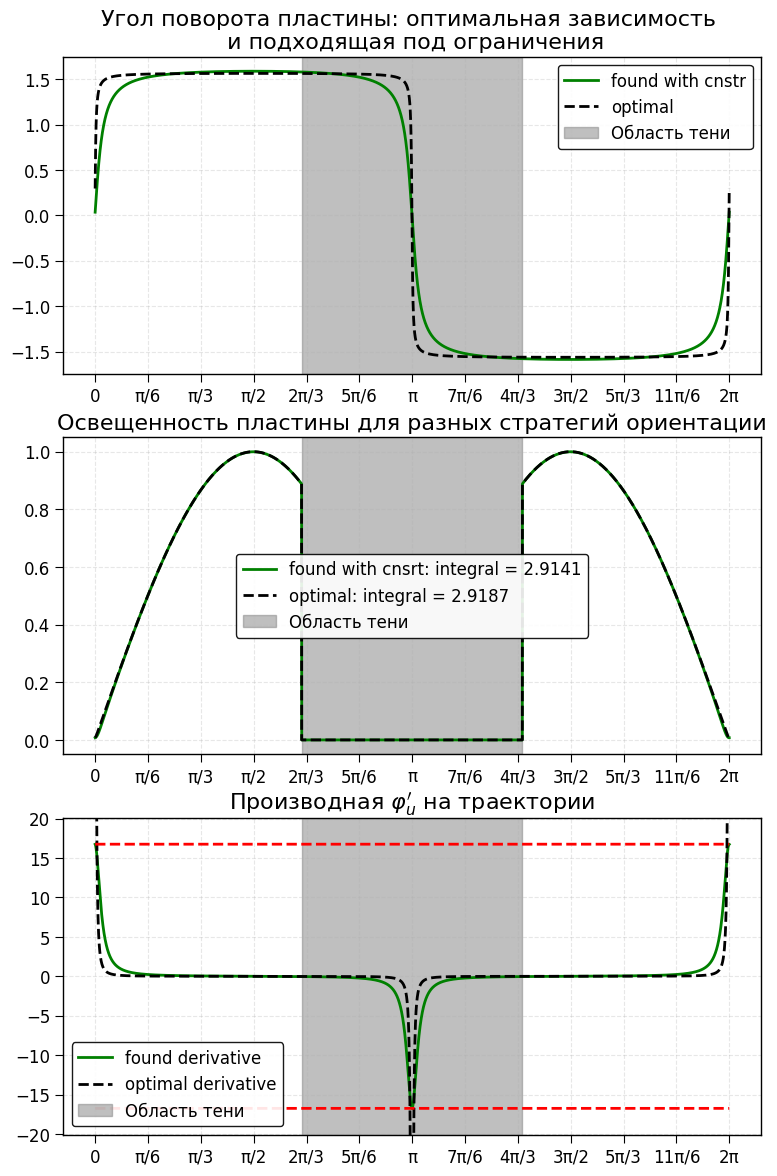

In [11]:
# Визуализируем результат

fig, ax = plt.subplots(nrows=3, figsize=(9, 14))

ax[0].plot(u_s, phi_found, 'g-', label='found with cnstr')
ax[0].plot(u_s, phi_opt, '--', color='black', label='optimal')
ax[0].set_title("Угол поворота пластины: оптимальная зависимость \n и подходящая под ограничения")

# Расчет интеграла от освещённости на траектории (целевай функция оптимизации)
ill_opt = spacefraft_orientation.illuminance(u_s, phi_opt) * shadow
ill_found = spacefraft_orientation.illuminance(u_s, phi_found) * shadow
ill_opt_int = np.sum(ill_opt * (u_s[1] - u_s[0]))
ill_found_int = np.sum(ill_found * (u_s[1] - u_s[0]))

ax[1].plot(u_s, ill_found, 'g-', label=f'found with cnsrt: integral = {np.round(ill_found_int, 4)}')
ax[1].plot(u_s, ill_opt, '--', color='black', label=f'optimal: integral = {np.round(ill_opt_int, 4)}')
ax[1].set_title("Освещенность пластины для разных стратегий ориентации")

ax[2].plot(u_s, phi_der(u_s, result.x),'g-', label='found derivative')
ax[2].plot(u_s, spacefraft_orientation.derivative_of_optimal_phi(u_s), '--', color="black", label='optimal derivative')
ax[2].plot(u_s, np.ones_like(u_s) * optimizer.cnstr, 'r--')
ax[2].plot(u_s, np.ones_like(u_s) * -optimizer.cnstr, 'r--')
ax[2].set_ylim([np.min(phi_der(u_s, result.x)) * 1.2, np.max(phi_der(u_s, result.x)) * 1.2])
ax[2].set_title(r"Производная $\varphi^\prime_u$ на траектории")

for a in ax:
    ticks = [0, np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6, 
         np.pi, 7*np.pi/6, 4*np.pi/3, 3*np.pi/2, 5*np.pi/3, 11*np.pi/6, 2*np.pi]
    tick_labels = ['0', 'π/6', 'π/3', 'π/2', '2π/3', '5π/6', 
               'π', '7π/6', '4π/3', '3π/2', '5π/3', '11π/6', '2π']
    a.set_xticks(ticks, tick_labels)
    if with_shadow and u_shadow_starts != None:
            a.axvspan(u_shadow_starts, u_shadow_ends, alpha=0.5, color='grey', label='Область тени')
    a.legend()
    a.grid(True)

plt.show()

In [12]:
# Расчитываем необходимые кватериноны
q_o2sc_opt = np.array([spacefraft_orientation.orientation_in_orbital_frame(phi).elements for phi in phi_opt])

q_i2sc_opt = np.array([(orbital_frame_orientation.orbital_frame_orientation(u) * 
          spacefraft_orientation.orientation_in_orbital_frame(phi)).elements for (u, phi) in zip(u_s, phi_opt)])

q_o2sc_found = np.array([spacefraft_orientation.orientation_in_orbital_frame(phi).elements for phi in phi_found])

q_i2sc_found = np.array([(orbital_frame_orientation.orbital_frame_orientation(u) * 
          spacefraft_orientation.orientation_in_orbital_frame(phi)).elements for (u, phi) in zip(u_s, phi_found)])

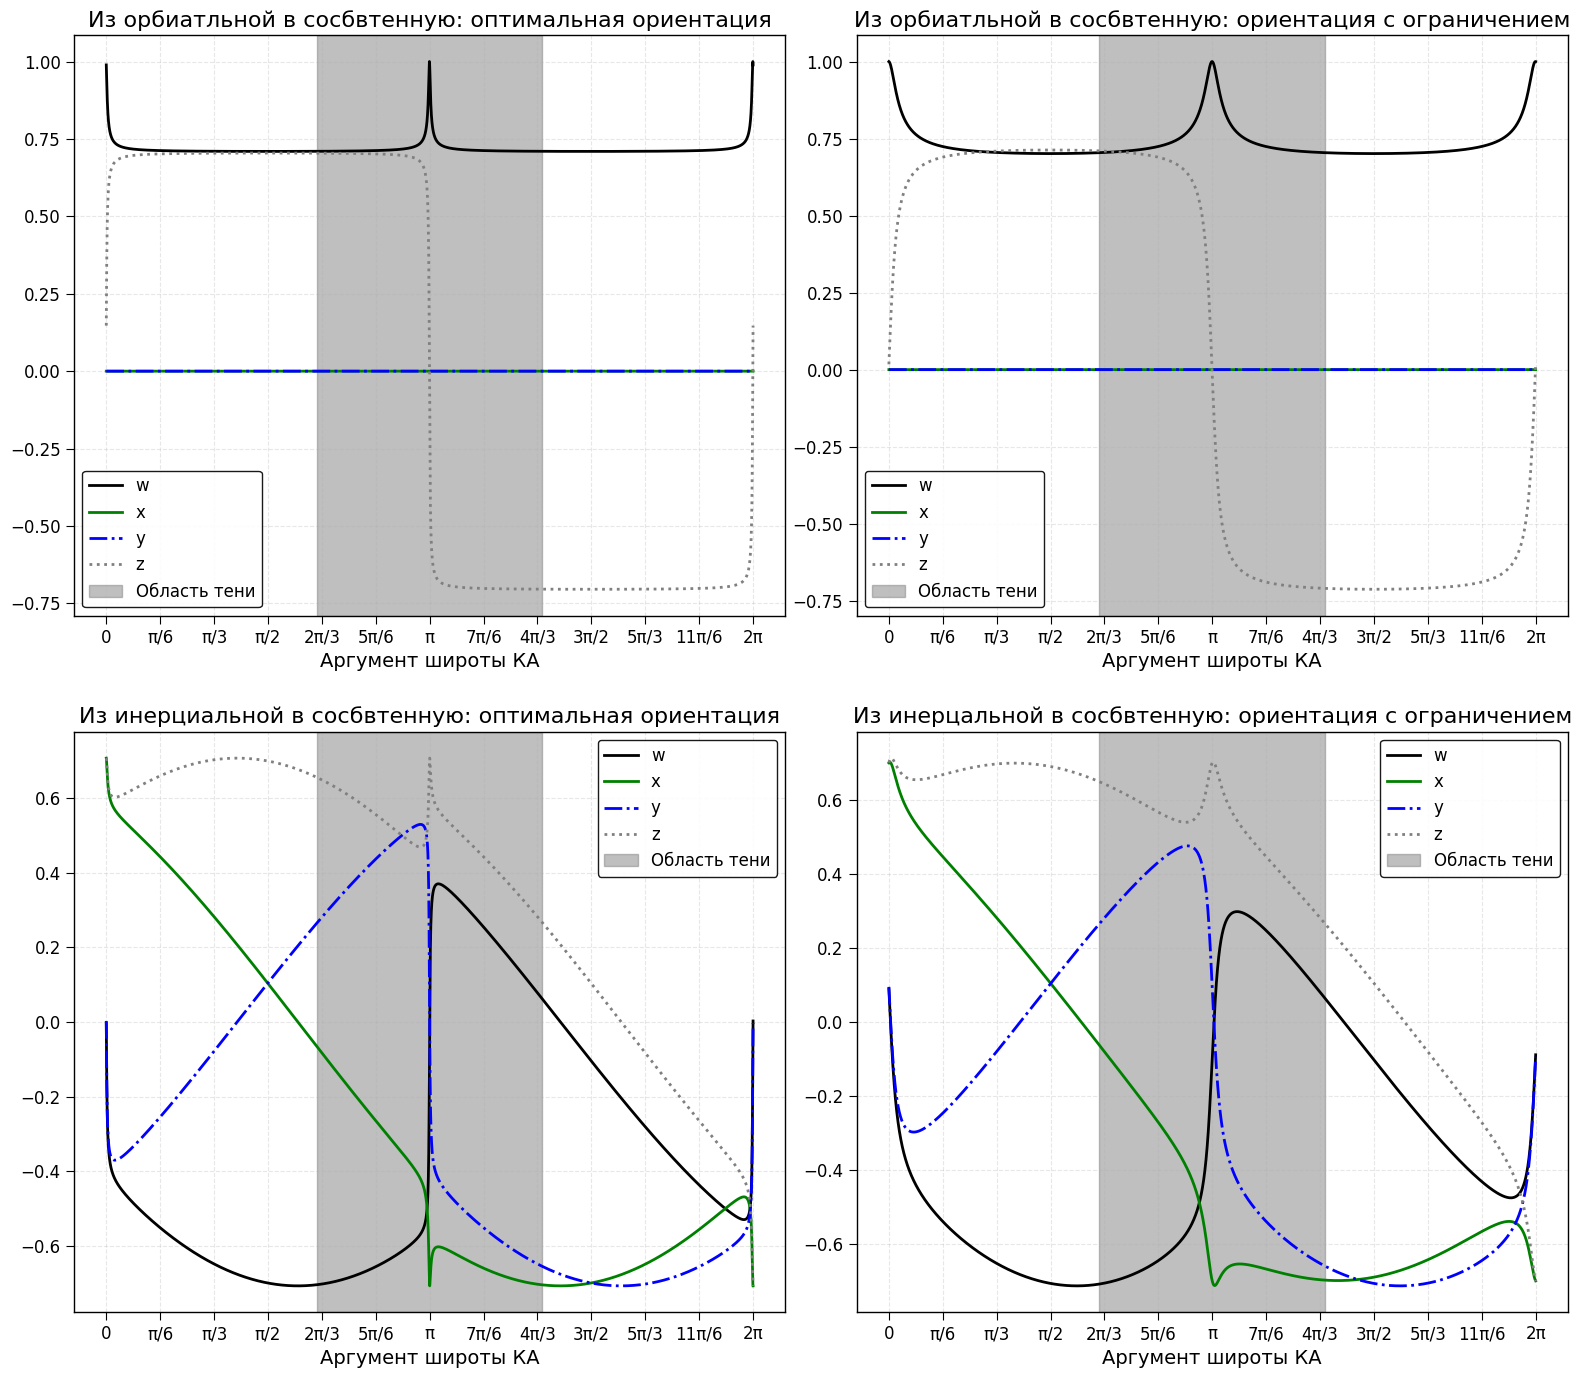

In [13]:
# Cравниваем ориентации по оптимальной стратении и по найденной
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 14))

ax[0][0].plot(u_s, q_o2sc_opt, label=('w', 'x', 'y', 'z'))
ax[0][0].set_title("Из орбиатльной в сосбвтенную: оптимальная ориентация")

ax[1][0].plot(u_s, q_i2sc_opt, label=('w', 'x', 'y', 'z'))
ax[1][0].set_title("Из инерциальной в сосбвтенную: оптимальная ориентация")

ax[0][1].plot(u_s, q_o2sc_found, label=('w', 'x', 'y', 'z'))
ax[0][1].set_title("Из орбиатльной в сосбвтенную: ориентация с ограничением")

ax[1][1].plot(u_s, q_i2sc_found, label=('w', 'x', 'y', 'z'))
ax[1][1].set_title("Из инерцальной в сосбвтенную: ориентация с ограничением")

for axes in ax:
    for axis in axes:
        ticks = [0, np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6, 
         np.pi, 7*np.pi/6, 4*np.pi/3, 3*np.pi/2, 5*np.pi/3, 11*np.pi/6, 2*np.pi]
        tick_labels = ['0', 'π/6', 'π/3', 'π/2', '2π/3', '5π/6', 
               'π', '7π/6', '4π/3', '3π/2', '5π/3', '11π/6', '2π']
        axis.set_xticks(ticks, tick_labels)
        if with_shadow and u_shadow_starts != None:
            axis.axvspan(u_shadow_starts, u_shadow_ends, alpha=0.5, color='grey', label='Область тени')
        axis.grid(True)
        axis.set_xlabel("Аргумент широты КА")
        axis.legend()


plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.2) 
plt.show()